<a href="https://colab.research.google.com/github/MelanieGarciaO/-TRABAJO-PR-CTICO-EXPERIMENTAL_IA/blob/main/DEEPLEARNING_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Crea las carpetas del proyecto en tu Drive (si no existen)
!mkdir -p "/content/drive/MyDrive/mango_project"
!mkdir -p "/content/drive/MyDrive/mango_dataset"


Mounted at /content/drive


In [ ]:
import os, random, shutil, math
from pathlib import Path

SEED = 42
random.seed(SEED)

SRC_DIR = Path("/content/drive/MyDrive/mango_dataset/archive")
DST_DIR = Path("/content/mango_leaves")  # copia temporal en Colab

def is_image(p):
    return p.suffix.lower() in {'.jpg','.jpeg','.png','.bmp','.tif','.tiff'}

classes = sorted([d.name for d in SRC_DIR.iterdir() if d.is_dir()])
print("Clases encontradas:", classes)

# Crear estructura
for split in ['train','val','test']:
    for c in classes:
        (DST_DIR/split/c).mkdir(parents=True, exist_ok=True)

# Dividir 70/15/15
for c in classes:
    imgs = [p for p in (SRC_DIR/c).glob('**/*') if p.is_file() and is_image(p)]
    random.shuffle(imgs)
    n = len(imgs)
    n_train = math.floor(0.7*n)
    n_val   = math.floor(0.15*n)
    train, val, test = imgs[:n_train], imgs[n_train:n_train+n_val], imgs[n_train+n_val:]
    for subset, split in [(train,'train'), (val,'val'), (test,'test')]:
        for p in subset:
            shutil.copy(p, DST_DIR/split/c/p.name)

print("✅ División completada en:", DST_DIR)


Clases encontradas: ['Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back', 'Gall Midge', 'Healthy', 'Powdery Mildew', 'Sooty Mould']
✅ División completada en: /content/mango_leaves


In [ ]:
import tensorflow as tf

IMG_SIZE_224 = (224,224)
IMG_SIZE_299 = (299,299)
BATCH = 32
AUTOTUNE = tf.data.AUTOTUNE

train_ds_224 = tf.keras.preprocessing.image_dataset_from_directory(
    DST_DIR / "train", image_size=IMG_SIZE_224, batch_size=BATCH, shuffle=True, seed=SEED)
val_ds_224 = tf.keras.preprocessing.image_dataset_from_directory(
    DST_DIR / "val", image_size=IMG_SIZE_224, batch_size=BATCH, shuffle=False, seed=SEED)
test_ds_224 = tf.keras.preprocessing.image_dataset_from_directory(
    DST_DIR / "test", image_size=IMG_SIZE_224, batch_size=BATCH, shuffle=False, seed=SEED)

# 299x299 para InceptionV3
train_ds_299 = tf.keras.preprocessing.image_dataset_from_directory(
    DST_DIR / "train", image_size=IMG_SIZE_299, batch_size=BATCH, shuffle=True, seed=SEED)
val_ds_299 = tf.keras.preprocessing.image_dataset_from_directory(
    DST_DIR / "val", image_size=IMG_SIZE_299, batch_size=BATCH, shuffle=False, seed=SEED)
test_ds_299 = tf.keras.preprocessing.image_dataset_from_directory(
    DST_DIR / "test", image_size=IMG_SIZE_299, batch_size=BATCH, shuffle=False, seed=SEED)

class_names = train_ds_224.class_names
NUM_CLASSES = len(class_names)
print("class_names =", class_names)


Found 2800 files belonging to 8 classes.
Found 600 files belonging to 8 classes.
Found 600 files belonging to 8 classes.
Found 2800 files belonging to 8 classes.
Found 600 files belonging to 8 classes.
Found 600 files belonging to 8 classes.
class_names = ['Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back', 'Gall Midge', 'Healthy', 'Powdery Mildew', 'Sooty Mould']


In [ ]:
data_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

def prepare(ds, training=False):
    ds = ds.cache()
    if training: ds = ds.shuffle(1000, seed=SEED)
    return ds.prefetch(AUTOTUNE)

train_ds_224 = prepare(train_ds_224, training=True)
val_ds_224   = prepare(val_ds_224)
test_ds_224  = prepare(test_ds_224)

train_ds_299 = prepare(train_ds_299, training=True)
val_ds_299   = prepare(val_ds_299)
test_ds_299  = prepare(test_ds_299)


In [ ]:
# ==== MobileNetV3 Large (224x224) ====
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, applications

# Pérdida y métricas comunes
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
metrics = [
    tf.keras.metrics.CategoricalAccuracy(name="acc"),
    tf.keras.metrics.TopKCategoricalAccuracy(k=2, name="top2"),
]

# One-hot al vuelo
def to_categorical(ds, num_classes):
    def _map(x, y):
        return x, tf.one_hot(y, num_classes)
    return ds.map(_map, num_parallel_calls=tf.data.AUTOTUNE)

# Cabeza común de clasificación
def classifier_head(x, num_classes, dropout=0.4):
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(num_classes, activation="softmax", dtype="float32")(x)
    return out

# Construcción del modelo MobileNetV3
def build_mobilenetv3_model(input_shape, num_classes):
    base = applications.MobileNetV3Large(
        include_top=False,
        input_shape=input_shape,
        weights="imagenet"
    )
    preprocess = applications.mobilenet_v3.preprocess_input

    inp = layers.Input(shape=input_shape)
    x = data_aug(inp)
    x = layers.Lambda(preprocess)(x)
    x = base(x, training=False)
    out = classifier_head(x, num_classes)

    model = models.Model(inp, out, name="MobileNetV3_mango")
    opt = optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5)
    model.compile(optimizer=opt, loss=loss_fn, metrics=metrics)
    return model, base

# Funciones para fine-tuning en 2 etapas
def unfreeze_tail(base_model, n_from_end):
    base_model.trainable = True
    # congelar todas menos las últimas n_from_end capas
    for layer in base_model.layers[:-abs(n_from_end)]:
        layer.trainable = False

def train_two_stage_mnet(model, base, train_ds, val_ds,
                         unfreeze_at=-30,
                         epochs_head=12, epochs_ft=20):
    early = tf.keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=6, restore_best_weights=True
    )
    plateau = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_acc", factor=0.5, patience=3, min_lr=1e-6, verbose=1
    )

    print("\n[1/2] Entrenando solo la cabeza (backbone congelado)")
    h1 = model.fit(
        to_categorical(train_ds, NUM_CLASSES),
        validation_data=to_categorical(val_ds, NUM_CLASSES),
        epochs=epochs_head,
        callbacks=[early, plateau],
        verbose=1
    )

    print("\n[2/2] Fine-tuning: desbloqueando parte final del backbone")
    unfreeze_tail(base, unfreeze_at)
    opt_ft = optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5)
    model.compile(optimizer=opt_ft, loss=loss_fn, metrics=metrics)

    h2 = model.fit(
        to_categorical(train_ds, NUM_CLASSES),
        validation_data=to_categorical(val_ds, NUM_CLASSES),
        epochs=epochs_ft,
        callbacks=[early, plateau],
        verbose=1
    )
    return h1, h2

# ==== Crear y entrenar MobileNetV3 ====
mnet, mnet_base = build_mobilenetv3_model((224,224,3), NUM_CLASSES)
h1_mnet, h2_mnet = train_two_stage_mnet(
    mnet, mnet_base,
    train_ds_224, val_ds_224,
    unfreeze_at=-30,      # cuántas capas dejar libres al final aprox
    epochs_head=12,
    epochs_ft=20
)


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

[1/2] Entrenando solo la cabeza (backbone congelado)
Epoch 1/12
88/88 ━━━━━━━━━━━━━━━━━━━━ 52s 142ms/step - acc: 0.8258 - loss: 0.9322 - top2: 0.8886 - val_acc: 0.7700 - val_loss: 1.2449 - val_top2: 0.8767 - learning_rate: 0.0010
Epoch 2/12
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - acc: 0.9985 - loss: 0.5199 - top2: 1.0000 - val_acc: 0.9500 - val_loss: 0.6595 - val_top2: 0.9917 - learning_rate: 0.0010
Epoch 3/12
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - acc: 0.9998 - loss: 0.4981 - top2: 1.0000 - val_acc: 0.9250 - val_loss: 0.6816 - val_top2: 0.9933 - learning_rate: 0.0010
Epoch 4/12
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - acc: 1.0000 - loss: 0.4917 - top2: 1.0000 - val_acc: 0.8950 - val_loss: 0.7391 - val_top2: 0.9967 - learning_rate: 0.0010
Epoch 5/12
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - acc: 1.0000 - loss: 0.4882 - top2: 1.0000 - val_acc: 0.9667 - val_loss: 0.5728 - val_top2: 0.9967 - learning_rate: 0.0010
Epoch 6/12
88/88 ━

In [ ]:
# ==== ResNet50 (224x224) ====
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, applications

# Reutilizamos loss_fn, metrics, to_categorical, classifier_head definidos antes

def build_resnet50_model(input_shape, num_classes):
    base = applications.ResNet50(
        include_top=False,
        input_shape=input_shape,
        weights="imagenet"
    )
    preprocess = applications.resnet.preprocess_input

    inp = layers.Input(shape=input_shape)
    x = data_aug(inp)
    x = layers.Lambda(preprocess)(x)
    x = base(x, training=False)
    out = classifier_head(x, num_classes)

    model = models.Model(inp, out, name="ResNet50_mango")
    opt = optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5)
    model.compile(optimizer=opt, loss=loss_fn, metrics=metrics)
    return model, base

def train_two_stage_resnet(model, base, train_ds, val_ds,
                           unfreeze_at=-50,
                           epochs_head=12, epochs_ft=20):
    early = tf.keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=6, restore_best_weights=True
    )
    plateau = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_acc", factor=0.5, patience=3, min_lr=1e-6, verbose=1
    )

    print("\n[1/2] ResNet50: entrenando solo la cabeza")
    h1 = model.fit(
        to_categorical(train_ds, NUM_CLASSES),
        validation_data=to_categorical(val_ds, NUM_CLASSES),
        epochs=epochs_head,
        callbacks=[early, plateau],
        verbose=1
    )

    print("\n[2/2] ResNet50: fine-tuning del tail")
    base.trainable = True
    for layer in base.layers[:-abs(unfreeze_at)]:
        layer.trainable = False

    opt_ft = optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5)
    model.compile(optimizer=opt_ft, loss=loss_fn, metrics=metrics)

    h2 = model.fit(
        to_categorical(train_ds, NUM_CLASSES),
        validation_data=to_categorical(val_ds, NUM_CLASSES),
        epochs=epochs_ft,
        callbacks=[early, plateau],
        verbose=1
    )
    return h1, h2

# ==== Crear y entrenar ResNet50 ====
resnet, resnet_base = build_resnet50_model((224,224,3), NUM_CLASSES)
h1_resnet, h2_resnet = train_two_stage_resnet(
    resnet, resnet_base,
    train_ds_224, val_ds_224,
    unfreeze_at=-50,      # deja libres ~50 capas finales
    epochs_head=12,
    epochs_ft=20
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

[1/2] ResNet50: entrenando solo la cabeza
Epoch 1/12
88/88 ━━━━━━━━━━━━━━━━━━━━ 55s 169ms/step - acc: 0.9088 - loss: 1.0118 - top2: 0.9544 - val_acc: 0.4267 - val_loss: 4.9834 - val_top2: 0.5583 - learning_rate: 0.0010
Epoch 2/12
88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - acc: 0.9841 - loss: 0.5772 - top2: 0.9989 - val_acc: 0.8400 - val_loss: 0.9533 - val_top2: 0.8917 - learning_rate: 0.0010
Epoch 3/12
88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - acc: 0.9932 - loss: 0.5315 - top2: 1.0000 - val_acc: 0.9933 - val_loss: 0.5293 - val_top2: 1.0000 - learning_rate: 0.0010
Epoch 4/12
88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - acc: 0.9994 - loss: 0.4987 - top2: 1.0000 - val_acc: 0.9883 - val_loss: 0.5545 - val_top2: 1.0000 - learning_rate: 0.0010
Epoch 5/12
88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - acc: 0.9995 - loss: 0.4935 - top2: 1.0000 - val_acc: 0.9917 - val_loss: 0.5289 - val_top2: 1.0000 - learning_rate: 0.0010
Epoch 6/12
88/88 ━━━━

In [ ]:
# ==== InceptionV3 (299x299) ====
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, applications

# ⚠️ Importante: crear una capa de data augmentation propia para 299x299
data_aug_299 = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
], name="data_aug_299")

# Reutilizamos loss_fn, metrics, to_categorical, classifier_head definidos en otros bloques

def build_inceptionv3_model(input_shape, num_classes):
    base = applications.InceptionV3(
        include_top=False,
        input_shape=input_shape,
        weights="imagenet"
    )
    preprocess = applications.inception_v3.preprocess_input

    inp = layers.Input(shape=input_shape)
    # 👉 Usamos data_aug_299, NO data_aug de 224
    x = data_aug_299(inp)
    x = layers.Lambda(preprocess)(x)
    x = base(x, training=False)
    out = classifier_head(x, num_classes)

    model = models.Model(inp, out, name="InceptionV3_mango")
    opt = optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5)
    model.compile(optimizer=opt, loss=loss_fn, metrics=metrics)
    return model, base

def train_two_stage_incept(model, base, train_ds, val_ds,
                           unfreeze_at=-80,
                           epochs_head=12, epochs_ft=20):
    early = tf.keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=6, restore_best_weights=True
    )
    plateau = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_acc", factor=0.5, patience=3, min_lr=1e-6, verbose=1
    )

    print("\n[1/2] InceptionV3: entrenando cabeza (backbone congelado)")
    h1 = model.fit(
        to_categorical(train_ds, NUM_CLASSES),
        validation_data=to_categorical(val_ds, NUM_CLASSES),
        epochs=epochs_head,
        callbacks=[early, plateau],
        verbose=1
    )

    print("\n[2/2] InceptionV3: fine-tuning del tail")
    base.trainable = True
    for layer in base.layers[:-abs(unfreeze_at)]:
        layer.trainable = False

    opt_ft = optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5)
    model.compile(optimizer=opt_ft, loss=loss_fn, metrics=metrics)

    h2 = model.fit(
        to_categorical(train_ds, NUM_CLASSES),
        validation_data=to_categorical(val_ds, NUM_CLASSES),
        epochs=epochs_ft,
        callbacks=[early, plateau],
        verbose=1
    )
    return h1, h2

# ==== Crear y entrenar InceptionV3 ====
incept, incept_base = build_inceptionv3_model((299,299,3), NUM_CLASSES)
h1_incept, h2_incept = train_two_stage_incept(
    incept, incept_base,
    train_ds_299, val_ds_299,
    unfreeze_at=-80,      # deja bastante cola libre para fine-tuning
    epochs_head=12,
    epochs_ft=20
)



[1/2] InceptionV3: entrenando cabeza (backbone congelado)
Epoch 1/12
88/88 ━━━━━━━━━━━━━━━━━━━━ 67s 219ms/step - acc: 0.9111 - loss: 0.9118 - top2: 0.9592 - val_acc: 0.3083 - val_loss: 2.7734 - val_top2: 0.4817 - learning_rate: 0.0010
Epoch 2/12
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - acc: 0.9793 - loss: 0.5571 - top2: 0.9983 - val_acc: 0.9150 - val_loss: 0.7116 - val_top2: 0.9783 - learning_rate: 0.0010
Epoch 3/12
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - acc: 0.9874 - loss: 0.5403 - top2: 0.9985 - val_acc: 0.7183 - val_loss: 1.1118 - val_top2: 0.9050 - learning_rate: 0.0010
Epoch 4/12
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - acc: 0.9962 - loss: 0.5072 - top2: 1.0000 - val_acc: 0.9850 - val_loss: 0.5237 - val_top2: 0.9967 - learning_rate: 0.0010
Epoch 5/12
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - acc: 0.9978 - loss: 0.4901 - top2: 1.0000 - val_acc: 0.5617 - val_loss: 2.0277 - val_top2: 0.8717 - learning_rate: 0.0010
Epoch 6/12
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - a

In [ ]:
# ==== CNN propia (SeparableConv + SE, 224x224) ====
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# Reutilizamos loss_fn, metrics, to_categorical

def se_block(x, r=8):
    c = x.shape[-1]
    s = layers.GlobalAveragePooling2D()(x)
    s = layers.Dense(c//r, activation='relu')(s)
    s = layers.Dense(c, activation='sigmoid')(s)
    s = layers.Reshape((1,1,c))(s)
    return layers.Multiply()([x, s])

def sep_block(x, f, stride=1):
    x = layers.SeparableConv2D(f, 3, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return se_block(x)

def build_cnn_propia(input_shape, num_classes):
    inp = layers.Input(shape=input_shape)
    x = data_aug(inp)
    x = layers.Rescaling(1./255)(x)

    x = layers.Conv2D(32, 3, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = sep_block(x, 64, 1)
    x = sep_block(x, 128, 2)
    x = sep_block(x, 128, 1)
    x = sep_block(x, 256, 2)
    x = sep_block(x, 256, 1)
    x = sep_block(x, 384, 2)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    out = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)

    model = models.Model(inp, out, name="CNN_Propia_mango")
    opt = optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5)
    model.compile(optimizer=opt, loss=loss_fn, metrics=metrics)
    return model

def train_cnn_propia(model, train_ds, val_ds,
                     epochs_head=20):
    early = tf.keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=6, restore_best_weights=True
    )
    plateau = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_acc", factor=0.5, patience=3, min_lr=1e-6, verbose=1
    )

    print("\nCNN Propia: entrenamiento completo (no hay backbone pre-entrenado)")
    h = model.fit(
        to_categorical(train_ds, NUM_CLASSES),
        validation_data=to_categorical(val_ds, NUM_CLASSES),
        epochs=epochs_head,
        callbacks=[early, plateau],
        verbose=1
    )
    return h

# ==== Crear y entrenar CNN propia ====
cnn_prop = build_cnn_propia((224,224,3), NUM_CLASSES)
h_cnn_prop = train_cnn_propia(
    cnn_prop,
    train_ds_224, val_ds_224,
    epochs_head=25
)



CNN Propia: entrenamiento completo (no hay backbone pre-entrenado)
Epoch 1/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - acc: 0.7557 - loss: 1.4168 - top2: 0.8645 - val_acc: 0.1250 - val_loss: 2.0812 - val_top2: 0.2500 - learning_rate: 0.0010
Epoch 2/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - acc: 0.8961 - loss: 0.7706 - top2: 0.9733 - val_acc: 0.1250 - val_loss: 2.0840 - val_top2: 0.2500 - learning_rate: 0.0010
Epoch 3/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - acc: 0.9369 - loss: 0.6721 - top2: 0.9886 - val_acc: 0.1250 - val_loss: 2.0875 - val_top2: 0.2500 - learning_rate: 0.0010
Epoch 4/25
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - acc: 0.9428 - loss: 0.6491 - top2: 0.9936
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - acc: 0.9429 - loss: 0.6490 - top2: 0.9935 - val_acc: 0.1250 - val_loss: 2.0857 - val_top2: 0.2500 - learning_rate: 0.0010
Epoch 5/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - acc: 0.9713 - loss


================ MobileNetV3 ================
                  precision    recall  f1-score   support

     Anthracnose     1.0000    1.0000    1.0000        75
Bacterial Canker     1.0000    0.9867    0.9933        75
  Cutting Weevil     1.0000    1.0000    1.0000        75
        Die Back     1.0000    1.0000    1.0000        75
      Gall Midge     0.9868    1.0000    0.9934        75
         Healthy     1.0000    1.0000    1.0000        75
  Powdery Mildew     1.0000    1.0000    1.0000        75
     Sooty Mould     1.0000    1.0000    1.0000        75

        accuracy                         0.9983       600
       macro avg     0.9984    0.9983    0.9983       600
    weighted avg     0.9984    0.9983    0.9983       600

Accuracy  : 0.9983
Macro-F1  : 0.9983


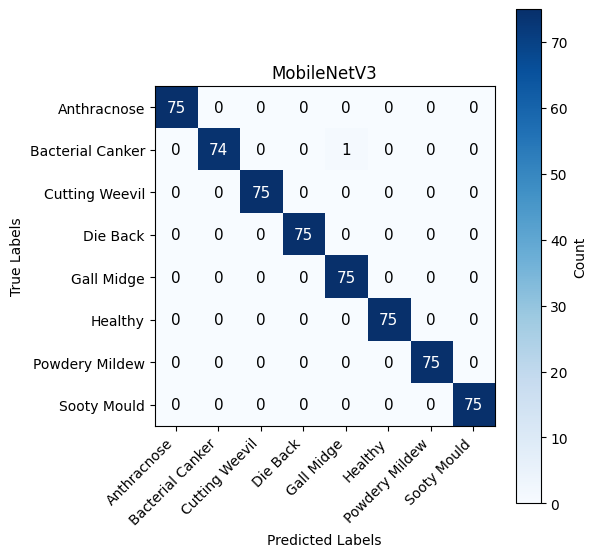


================ ResNet50 ================
                  precision    recall  f1-score   support

     Anthracnose     0.9868    1.0000    0.9934        75
Bacterial Canker     1.0000    1.0000    1.0000        75
  Cutting Weevil     1.0000    1.0000    1.0000        75
        Die Back     1.0000    0.9867    0.9933        75
      Gall Midge     1.0000    1.0000    1.0000        75
         Healthy     1.0000    1.0000    1.0000        75
  Powdery Mildew     1.0000    1.0000    1.0000        75
     Sooty Mould     1.0000    1.0000    1.0000        75

        accuracy                         0.9983       600
       macro avg     0.9984    0.9983    0.9983       600
    weighted avg     0.9984    0.9983    0.9983       600

Accuracy  : 0.9983
Macro-F1  : 0.9983


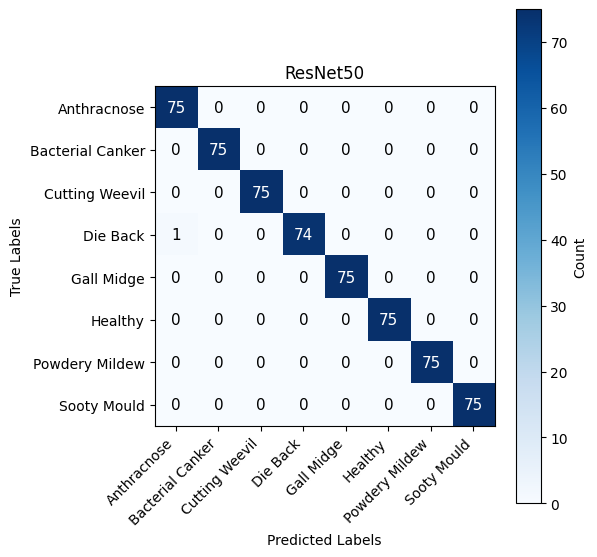


================ InceptionV3 ================
                  precision    recall  f1-score   support

     Anthracnose     1.0000    1.0000    1.0000        75
Bacterial Canker     1.0000    1.0000    1.0000        75
  Cutting Weevil     1.0000    1.0000    1.0000        75
        Die Back     1.0000    1.0000    1.0000        75
      Gall Midge     1.0000    1.0000    1.0000        75
         Healthy     1.0000    1.0000    1.0000        75
  Powdery Mildew     1.0000    1.0000    1.0000        75
     Sooty Mould     1.0000    1.0000    1.0000        75

        accuracy                         1.0000       600
       macro avg     1.0000    1.0000    1.0000       600
    weighted avg     1.0000    1.0000    1.0000       600

Accuracy  : 1.0000
Macro-F1  : 1.0000


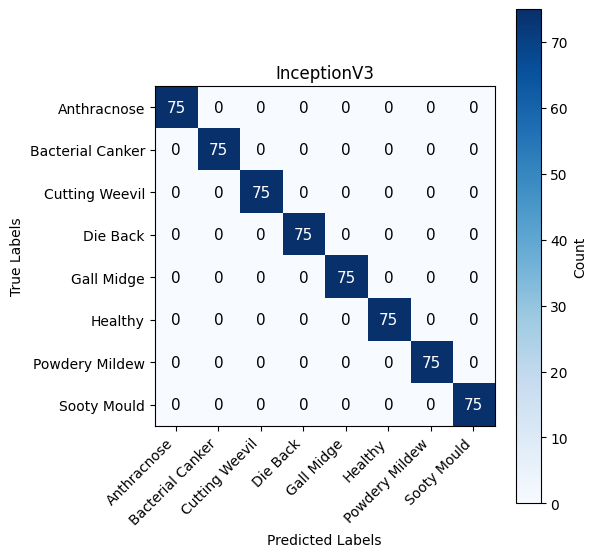


================ CNN_Propia ================
                  precision    recall  f1-score   support

     Anthracnose     1.0000    0.9600    0.9796        75
Bacterial Canker     0.9868    1.0000    0.9934        75
  Cutting Weevil     0.9740    1.0000    0.9868        75
        Die Back     1.0000    1.0000    1.0000        75
      Gall Midge     0.9737    0.9867    0.9801        75
         Healthy     1.0000    1.0000    1.0000        75
  Powdery Mildew     1.0000    0.9867    0.9933        75
     Sooty Mould     0.9867    0.9867    0.9867        75

        accuracy                         0.9900       600
       macro avg     0.9902    0.9900    0.9900       600
    weighted avg     0.9902    0.9900    0.9900       600

Accuracy  : 0.9900
Macro-F1  : 0.9900


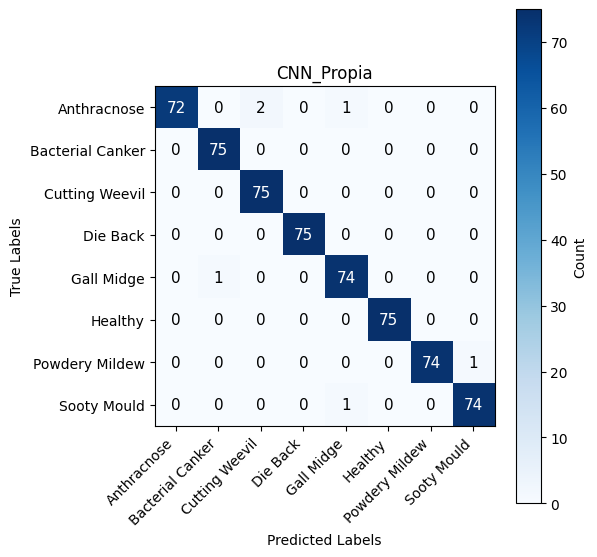


===== Tabla comparativa (Accuracy, Macro-F1) =====
MobileNetV3   Acc=0.9983  Macro-F1=0.9983
ResNet50      Acc=0.9983  Macro-F1=0.9983
InceptionV3   Acc=1.0000  Macro-F1=1.0000
CNN_Propia    Acc=0.9900  Macro-F1=0.9900


In [ ]:
# ====== Evaluación de todos los modelos ======
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score

def eval_model(model, test_ds, name, class_names):
    # y_true: etiquetas enteras
    y_true = []
    for _, y in test_ds:
        y_true.extend(y.numpy())
    y_true = np.array(y_true)

    # predicciones
    y_pred = model.predict(test_ds, verbose=0)
    y_hat = np.argmax(y_pred, axis=1)

    print(f"\n================ {name} ================")
    print(classification_report(y_true, y_hat, target_names=class_names, digits=4))

    acc = (y_true == y_hat).mean()
    macro_f1 = f1_score(y_true, y_hat, average='macro')
    print(f"Accuracy  : {acc:.4f}")
    print(f"Macro-F1  : {macro_f1:.4f}")

    # Matriz de confusión con estilo mejorado
    cm = confusion_matrix(y_true, y_hat)

    plt.figure(figsize=(6,6))
    im = plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(name)
    plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
    plt.yticks(range(len(class_names)), class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    cbar = plt.colorbar(im)
    cbar.ax.set_ylabel("Count")

    # Escribir los valores dentro de cada celda
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = cm[i, j]
            color = "white" if value > thresh else "black"
            plt.text(j, i, str(value),
                     ha="center", va="center",
                     color=color, fontsize=11)

    plt.tight_layout()
    plt.show()

    return acc, macro_f1

# Evaluar cada modelo
results = {}
results['MobileNetV3'] = eval_model(mnet,     test_ds_224, "MobileNetV3", class_names)
results['ResNet50']    = eval_model(resnet,   test_ds_224, "ResNet50",    class_names)
results['InceptionV3'] = eval_model(incept,   test_ds_299, "InceptionV3", class_names)
results['CNN_Propia']  = eval_model(cnn_prop, test_ds_224, "CNN_Propia",  class_names)

print("\n===== Tabla comparativa (Accuracy, Macro-F1) =====")
for name, (acc, mf1) in results.items():
    print(f"{name:12s}  Acc={acc:.4f}  Macro-F1={mf1:.4f}")


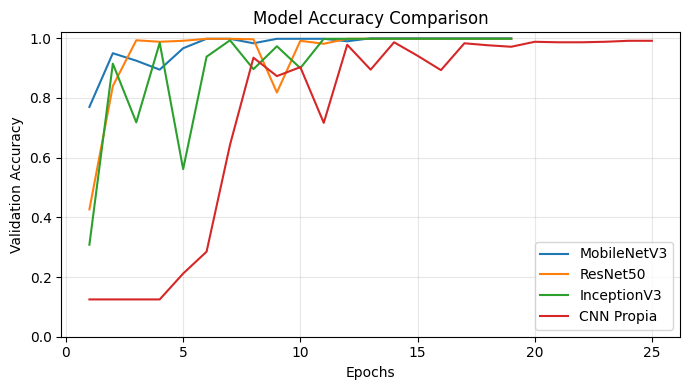

In [ ]:
#Comparación de Accuracy vs Epoch (4 modelos)
import matplotlib.pyplot as plt

def merge_history(h1, h2=None):
    acc      = list(h1.history.get("acc", []))
    val_acc  = list(h1.history.get("val_acc", []))
    if h2 is not None:
        acc     += list(h2.history.get("acc", []))
        val_acc += list(h2.history.get("val_acc", []))
    epochs = list(range(1, len(acc) + 1))
    return epochs, acc, val_acc

# Unimos historias
e_m, acc_m, val_acc_m = merge_history(h1_mnet,   h2_mnet)
e_r, acc_r, val_acc_r = merge_history(h1_resnet, h2_resnet)
e_i, acc_i, val_acc_i = merge_history(h1_incept, h2_incept)
e_c, acc_c, val_acc_c = merge_history(h_cnn_prop)  # solo una fase

plt.figure(figsize=(7,4))
plt.plot(e_m, val_acc_m, label="MobileNetV3")
plt.plot(e_r, val_acc_r, label="ResNet50")
plt.plot(e_i, val_acc_i, label="InceptionV3")
plt.plot(e_c, val_acc_c, label="CNN Propia")

plt.title("Model Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.ylim(0, 1.02)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


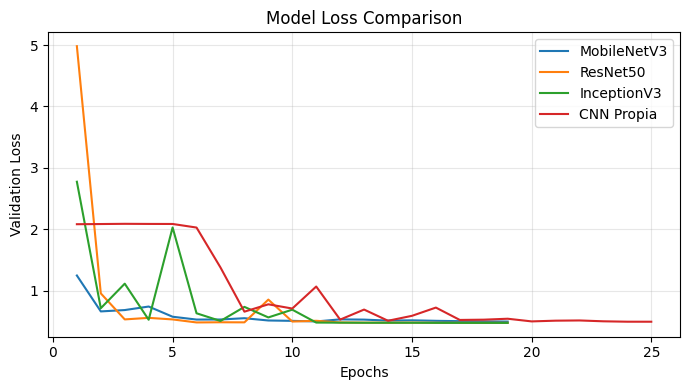

In [ ]:
#Comparación de Loss vs Epoch (4 modelos)
import matplotlib.pyplot as plt

def merge_loss(h1, h2=None):
    loss     = list(h1.history.get("loss", []))
    val_loss = list(h1.history.get("val_loss", []))
    if h2 is not None:
        loss     += list(h2.history.get("loss", []))
        val_loss += list(h2.history.get("val_loss", []))
    epochs = list(range(1, len(loss) + 1))
    return epochs, loss, val_loss

e_m_l, loss_m, val_loss_m = merge_loss(h1_mnet,   h2_mnet)
e_r_l, loss_r, val_loss_r = merge_loss(h1_resnet, h2_resnet)
e_i_l, loss_i, val_loss_i = merge_loss(h1_incept, h2_incept)
e_c_l, loss_c, val_loss_c = merge_loss(h_cnn_prop)

plt.figure(figsize=(7,4))
plt.plot(e_m_l, val_loss_m, label="MobileNetV3")
plt.plot(e_r_l, val_loss_r, label="ResNet50")
plt.plot(e_i_l, val_loss_i, label="InceptionV3")
plt.plot(e_c_l, val_loss_c, label="CNN Propia")

plt.title("Model Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


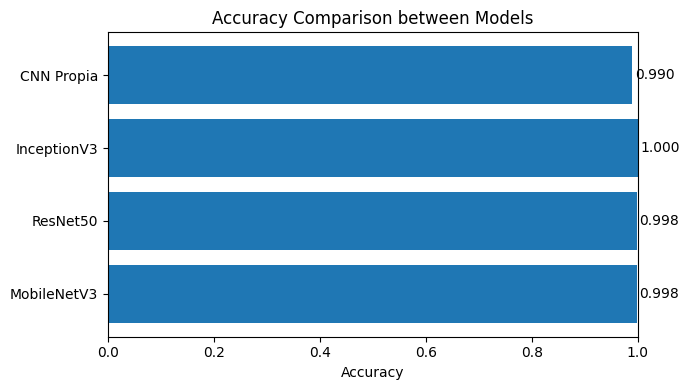

In [ ]:
#Accuracy global por modelo
import numpy as np
import matplotlib.pyplot as plt

def test_accuracy(model, test_ds):
    y_true = []
    for _, y in test_ds:
        y_true.extend(y.numpy())
    y_true = np.array(y_true)
    y_pred = model.predict(test_ds, verbose=0)
    y_hat  = np.argmax(y_pred, axis=1)
    return (y_true == y_hat).mean()

acc_m = test_accuracy(mnet,     test_ds_224)
acc_r = test_accuracy(resnet,   test_ds_224)
acc_i = test_accuracy(incept,   test_ds_299)
acc_c = test_accuracy(cnn_prop, test_ds_224)

model_names = ["MobileNetV3", "ResNet50", "InceptionV3", "CNN Propia"]
acc_values  = [acc_m, acc_r, acc_i, acc_c]

plt.figure(figsize=(7,4))
y_pos = np.arange(len(model_names))
plt.barh(y_pos, acc_values)
plt.yticks(y_pos, model_names)
plt.xlabel("Accuracy")
plt.xlim(0, 1.0)
for i, v in enumerate(acc_values):
    plt.text(v + 0.005, i, f"{v:.3f}", va="center")
plt.title("Accuracy Comparison between Models")
plt.tight_layout()
plt.show()


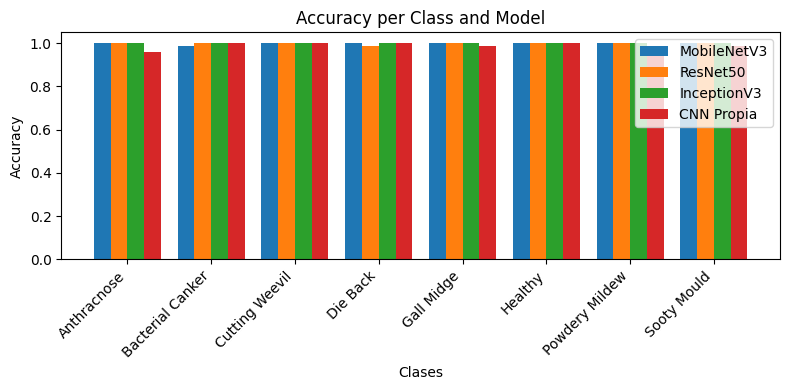

In [ ]:
#Accuracy por clase y modelo
import numpy as np
import matplotlib.pyplot as plt

def per_class_accuracy(model, test_ds, num_classes):
    y_true = []
    for _, y in test_ds:
        y_true.extend(y.numpy())
    y_true = np.array(y_true)

    y_pred = model.predict(test_ds, verbose=0)
    y_hat  = np.argmax(y_pred, axis=1)

    acc_per_class = []
    for c in range(num_classes):
        idx = (y_true == c)
        if idx.sum() == 0:
            acc_per_class.append(0.0)
        else:
            acc_per_class.append((y_hat[idx] == c).mean())
    return np.array(acc_per_class)

acc_per_class_m = per_class_accuracy(mnet,     test_ds_224, NUM_CLASSES)
acc_per_class_r = per_class_accuracy(resnet,   test_ds_224, NUM_CLASSES)
acc_per_class_i = per_class_accuracy(incept,   test_ds_299, NUM_CLASSES)
acc_per_class_c = per_class_accuracy(cnn_prop, test_ds_224, NUM_CLASSES)

x = np.arange(NUM_CLASSES)
width = 0.2

plt.figure(figsize=(8,4))
plt.bar(x - 1.5*width, acc_per_class_m, width, label="MobileNetV3")
plt.bar(x - 0.5*width, acc_per_class_r, width, label="ResNet50")
plt.bar(x + 0.5*width, acc_per_class_i, width, label="InceptionV3")
plt.bar(x + 1.5*width, acc_per_class_c, width, label="CNN Propia")

plt.xticks(x, class_names, rotation=45, ha="right")
plt.ylim(0, 1.05)
plt.ylabel("Accuracy")
plt.xlabel("Clases")
plt.title("Accuracy per Class and Model")
plt.legend()
plt.tight_layout()
plt.show()


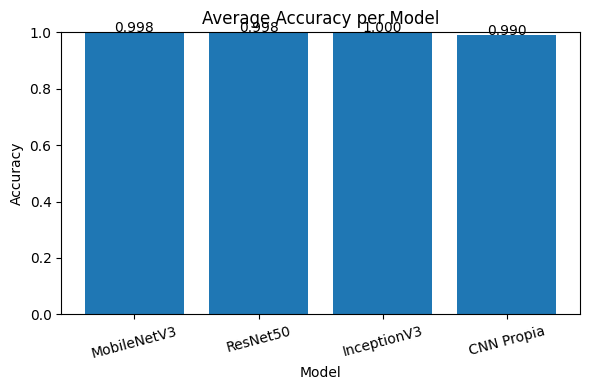

In [ ]:
#Accuracy promedio por modelo
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
x = np.arange(len(model_names))
plt.bar(x, acc_values)
plt.xticks(x, model_names, rotation=15)
plt.ylim(0, 1.0)  # ajusta según tus resultados
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.title("Average Accuracy per Model")

for i, v in enumerate(acc_values):
    plt.text(i, v + 0.002, f"{v:.3f}", ha="center")

plt.tight_layout()
plt.show()


Saving IMG_20211106_143036 (Custom).jpg to IMG_20211106_143036 (Custom).jpg
Imagen recibida: IMG_20211106_143036 (Custom).jpg


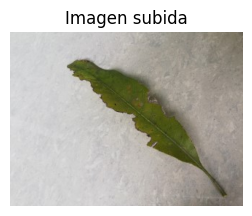

NameError: name 'mnet' is not defined

In [ ]:
#PRUEBA
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# === 1. Subir imagen desde tu PC ===
uploaded = files.upload()

if not uploaded:
    raise ValueError("No se subió ninguna imagen.")

img_name = list(uploaded.keys())[0]
print(f"Imagen recibida: {img_name}")

# === 2. Mostrar imagen original ===
img = load_img(img_name)
plt.figure(figsize=(3,3))
plt.imshow(img)
plt.axis("off")
plt.title("Imagen subida")
plt.show()

# === 3. Funciones auxiliares ===
def prep_array(pil_img, size):

    arr = pil_img.resize(size)
    arr = img_to_array(arr).astype("float32")
    arr = np.expand_dims(arr, axis=0)
    return arr

def predict_with(model, x, model_name, class_names, top_k=3):
    """Devuelve top-1 y top-k predicciones de un modelo."""
    probs = model.predict(x, verbose=0)[0]
    order = np.argsort(probs)[-top_k:][::-1]
    top1_idx = int(order[0])
    top1_class = class_names[top1_idx]
    top1_prob  = float(probs[top1_idx])
    topk = [(class_names[i], float(probs[i])) for i in order]
    return {
        "model": model_name,
        "top1_class": top1_class,
        "top1_prob": top1_prob,
        "topk": topk,
    }

# === 4. Preparar tensores para 224x224 y 299x299 ===
x_224 = prep_array(img, (224, 224))
x_299 = prep_array(img, (299, 299))

# === 5. Ejecutar los 4 modelos ===
results = []
results.append(predict_with(mnet,     x_224, "MobileNetV3", class_names))
results.append(predict_with(resnet,   x_224, "ResNet50",    class_names))
results.append(predict_with(cnn_prop, x_224, "CNN Propia",  class_names))
results.append(predict_with(incept,   x_299, "InceptionV3", class_names))

# === 6. Mostrar resultados comparativos ===
print("\n===== Comparación de predicciones por modelo =====\n")
for r in results:
    print(f"Modelo: {r['model']}")
    print(f"  Top-1: {r['top1_class']}  (prob = {r['top1_prob']:.4f})")
    print("  Top-3:")
    for cls, p in r["topk"]:
        print(f"    - {cls:20s}  {p:.4f}")
    print()


In [ ]:
import os, json

PROJECT_DIR = "/content/drive/MyDrive/mango_project"
os.makedirs(PROJECT_DIR, exist_ok=True)

# 1) Guardar CADA modelo con su propio nombre
MNET_PATH   = os.path.join(PROJECT_DIR, "mango_mnet.keras")
RESNET_PATH = os.path.join(PROJECT_DIR, "mango_resnet.keras")
INCEPT_PATH = os.path.join(PROJECT_DIR, "mango_incept.keras")
CNNP_PATH   = os.path.join(PROJECT_DIR, "mango_cnnprop.keras")

mnet.save(MNET_PATH)
resnet.save(RESNET_PATH)
incept.save(INCEPT_PATH)
cnn_prop.save(CNNP_PATH)

print("✅ Modelos guardados:")
print(" -", MNET_PATH)
print(" -", RESNET_PATH)
print(" -", INCEPT_PATH)
print(" -", CNNP_PATH)

# 2) Guardar el orden de las clases (el mismo para todos)
CLASSES_JSON = os.path.join(PROJECT_DIR, "classes.json")
with open(CLASSES_JSON, "w", encoding="utf-8") as f:
    json.dump({"classes": class_names}, f, ensure_ascii=False, indent=2)

# 3) Guardar config con info de cada modelo (nombre, archivo, tamaño de entrada)
CONFIG_JSON = os.path.join(PROJECT_DIR, "models_config.json")
models_cfg = {
    "models": [
        {"name": "MobileNetV3", "file": "mango_mnet.keras",   "input_size": [224, 224]},
        {"name": "ResNet50",    "file": "mango_resnet.keras", "input_size": [224, 224]},
        {"name": "InceptionV3", "file": "mango_incept.keras", "input_size": [299, 299]},
        {"name": "CNN Propia",  "file": "mango_cnnprop.keras","input_size": [224, 224]},
    ]
}
with open(CONFIG_JSON, "w", encoding="utf-8") as f:
    json.dump(models_cfg, f, ensure_ascii=False, indent=2)

print("✅ classes.json y models_config.json guardados en", PROJECT_DIR)


NameError: name 'mnet' is not defined

In [ ]:
!pip -q install streamlit pillow tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 125.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 128.5 MB/s eta 0:00:00


In [ ]:
%%bash
cat > app.py << 'PY'
import os, json
import numpy as np
from PIL import Image
import streamlit as st
import tensorflow as tf
from tensorflow.keras import applications

PROJECT_DIR   = "/content/drive/MyDrive/mango_project"
CLASSES_JSON  = os.path.join(PROJECT_DIR, "classes.json")
MODELS_CONFIG = os.path.join(PROJECT_DIR, "models_config.json")

@st.cache_resource(show_spinner=False)
def load_artifacts():
    # Cargar clases
    with open(CLASSES_JSON, "r", encoding="utf-8") as f:
        classes = json.load(f)["classes"]

    # Cargar config de modelos
    with open(MODELS_CONFIG, "r", encoding="utf-8") as f:
        cfg = json.load(f)["models"]

    # 👇 Mapeo para que Keras pueda deserializar la Lambda(preprocess_input)
    # Usamos la versión de MobileNetV3. Todos los modelos tienen una Lambda
    # cuyo nombre serializado es simplemente "preprocess_input".
    custom_objects = {
        "preprocess_input": applications.mobilenet_v3.preprocess_input
    }

    loaded_models = []
    for m in cfg:
        model_path = os.path.join(PROJECT_DIR, m["file"])
        model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)
        loaded_models.append({
            "name": m["name"],
            "input_size": tuple(m["input_size"]),
            "model": model,
        })
    return classes, loaded_models

def prepare_image(img: Image.Image, size):
    """Redimensiona y devuelve batch (1, H, W, 3) en float32."""
    img = img.convert("RGB").resize(size)
    x = np.array(img, dtype=np.float32)[None, ...]
    # Los modelos ya incluyen preprocess interno (Lambda), no normalizamos más.
    return x

def predict_with(model, x, class_names, top_k=3):
    probs = model.predict(x, verbose=0)[0]
    order = np.argsort(probs)[-top_k:][::-1]
    top1_idx = int(order[0])
    top1_class = class_names[top1_idx]
    top1_prob  = float(probs[top1_idx])
    topk = [(class_names[i], float(probs[i])) for i in order]
    return top1_class, top1_prob, topk

# ================= INTERFAZ STREAMLIT =================
st.set_page_config(page_title="Mango Leaf Classifier (4 modelos)", layout="wide")
st.title("🍃 Mango Leaf Disease — Comparación de Modelos")

classes, models_info = load_artifacts()
st.success(f"Modelos cargados: {', '.join(m['name'] for m in models_info)}")

file = st.file_uploader("Sube una imagen de hoja de mango", type=["jpg","jpeg","png"])
if file is None:
    st.info("Carga una imagen para ver las predicciones de los 4 modelos.")
    st.stop()

img = Image.open(file)
st.image(img, caption="Imagen subida", use_column_width=False, width=300)

st.markdown("---")
st.subheader("Resultados por modelo")

cols = st.columns(len(models_info))

for col, info in zip(cols, models_info):
    with col:
        st.markdown(f"### {info['name']}")
        x = prepare_image(img, info["input_size"])
        top1_class, top1_prob, topk = predict_with(info["model"], x, classes, top_k=3)

        st.write(f"**Top-1:** {top1_class}  (prob = {top1_prob:.3f})")
        st.write("Top-3:")
        for cls, p in topk:
            st.write(f"- {cls}: {p:.3f}")
PY


In [ ]:
# ============================================================
# BLOQUE MAESTRO: Drive + Streamlit + Ngrok + Log de errores
# ============================================================

# 1) Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2) Rutas de la app
APP_IN_DRIVE = "/content/app.py"  # ajusta si tu app está en otra carpeta
APP_LOCAL    = "/content/app.py"

import os, time

# 3) Copiar app.py desde Drive a /content si no está (o forzar copia)
if not os.path.exists(APP_IN_DRIVE):
    raise FileNotFoundError(f"No encuentro {APP_IN_DRIVE}. Verifica la ruta en Drive.")
!cp -f "{APP_IN_DRIVE}" "{APP_LOCAL}"
print("✅ app.py copiado a /content")

# 4) Instalar dependencias
!pip -q install streamlit pyngrok

# 5) Configurar ngrok
from pyngrok import ngrok
NGROK_TOKEN = "35PhVvG01BtkMjaaBNVm8hRUmcv_3a2aAgBGmqX4xM9c9W56t"  # <-- SOLO el token, sin 'ngrok config add-authtoken'
ngrok.set_auth_token(NGROK_TOKEN)
print("✅ ngrok configurado")

# 6) Cerrar cualquier streamlit viejo
!pkill -f "streamlit run" || echo "No había procesos previos de streamlit."

# 7) Lanzar Streamlit en segundo plano, log en /content/streamlit.log
!streamlit run "{APP_LOCAL}" --server.port 8501 &> /content/streamlit.log &

# Esperar unos segundos a que arranque
time.sleep(7)

print("\n===== Últimas líneas del log de Streamlit =====")
!tail -n 40 /content/streamlit.log || echo "No hay log todavía."

# 8) Crear túnel ngrok al puerto 8501
public_url = ngrok.connect(8501, bind_tls=True)
print("\n🌐 Tu app está disponible en:", public_url)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: '/content/app.py' and '/content/app.py' are the same file
✅ app.py copiado a /content
✅ ngrok configurado
^C

===== Últimas líneas del log de Streamlit =====


2025-11-15 05:32:20.749 Port 8501 is already in use

🌐 Tu app está disponible en: NgrokTunnel: "https://transportedly-bicollateral-randell.ngrok-free.dev" -> "http://localhost:8501"


In [ ]:
# 1) Montar Drive (por si acaso)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 2) Asegurar que app.py esté en /content
APP_IN_DRIVE = "/content/app.py"
APP_LOCAL    = "/content/app.py"

import os, time

if not os.path.exists(APP_IN_DRIVE):
    raise FileNotFoundError(f"No encuentro {APP_IN_DRIVE}. Ajusta la ruta si es distinta.")
!cp -f "{APP_IN_DRIVE}" "{APP_LOCAL}"
print("✅ app.py copiado a /content")

# 3) Instalar dependencias
!pip -q install streamlit pyngrok

# 4) Configurar ngrok (SOLO el token)
from pyngrok import ngrok
NGROK_TOKEN = "AQUI_TU_TOKEN"   # <-- cambia esto
ngrok.set_auth_token(NGROK_TOKEN)
print("✅ ngrok configurado")

# 5) Matar cualquier streamlit / proceso en 8501
!pkill -f "streamlit run" || echo "No había procesos previos de streamlit."
!fuser -k 8501/tcp || echo "No había nada usando el puerto 8501."

# 6) Lanzar Streamlit de nuevo
!streamlit run "{APP_LOCAL}" --server.port 8501 &> /content/streamlit.log &

# Esperar a que arranque
time.sleep(7)

print("\n===== Últimas líneas del log de Streamlit =====")
!tail -n 40 /content/streamlit.log || echo "No hay log todavía."

# 7) Crear túnel ngrok
public_url = ngrok.connect(8501, bind_tls=True)
print("\n🌐 Tu app está disponible en:", public_url)


Mounted at /content/drive
cp: '/content/app.py' and '/content/app.py' are the same file
✅ app.py copiado a /content
✅ ngrok configurado
^C
No había nada usando el puerto 8501.

===== Últimas líneas del log de Streamlit =====


2025-11-15 05:32:20.749 Port 8501 is already in use

🌐 Tu app está disponible en: NgrokTunnel: "https://transportedly-bicollateral-randell.ngrok-free.dev" -> "http://localhost:8501"
